# Generate Color and Age Maps

The final step before moving on to Blender is generating the color and age maps. For this, we will use an image processing library named [Pillow](https://pillow.readthedocs.io/en/stable/).

### The Problem With 16-bit Age Maps

In my first renders, I simply saved the age of each pixel as a 16-bit integer in the age maps. If we record the pixel value as the age of the pixel in milliseconds, that means the pixel has an "age resolution" of 1 millisecond with a maximum age of 65.535 seconds. If we change the age resolution 100 milliseconds, that means we have a maximum age of 65,535 * 100 milliseconds = 6,553.5 seconds.

Setting the age resolution too high results in short lived pixels. Setting the age resolution too low results in several pixels that have the same age, and are less accurate.

However, this problem can be overcome with some math. Consider our final render, where the pixel's age corresponds to its height in the image. The heights of the pixels will be the most varied in the moments right after the pixel is changed. As the pixel gets older, it's change in height over time will be smaller and less important.

It would be nice if we could trade some of the unnecessary resolution in our old pixels for higher resolution in our new pixels. Fortunately, we can do this with logarithms.

Let's quickly review what a logarithmic scale looks like.

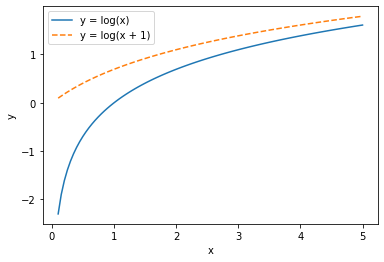

<Figure size 432x288 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.1, 5, 100)
y1 = np.log(x)
y2 = np.log(x + 1)

plt.plot(x, y1)
plt.plot(x, y2, linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['y = log(x)', 'y = log(x + 1)'])

fig = plt.figure()
plt.show()

Notice how for log(x), y approaches negative infinity as x decreases to zero. Pixels start with an age of zero, and negative infinity doesn't fit in a `uint16` pixel value. This can be fixed by simply adding 1 to `x`, which makes `y` equal to zero when `x` equals zero.

How can using `log` help us reach our goal of trading age resolution on the high end for age resolution on the low end? Consider how the values for `x` near zero cover a much wider range of `y` of compared to higher values of `x`. This can be useful to us, since we want high age resolution for low (new) values, but we don't care so much about age resolution for high (old) values.

We just need to scale the curve so that the it has the desired steepness (we'll call this 'compression'), and the oldest pixels have a value close to the maximum value of a 16-bit `uint` (65545).

We will do this with a function called `age_to_val()`:

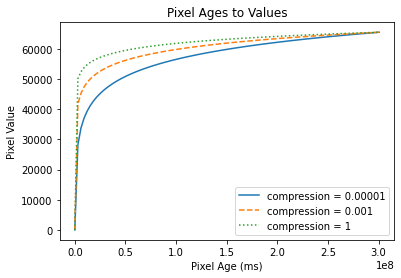

<Figure size 432x288 with 0 Axes>

In [2]:

UINT16_MAX = 65_535
TIMESTAMP_MAX = 300_589_892

def age_to_val(px_age, compression=0.001):
    """Convert a pixel age into a 16-bit value.

    Higher compression values make the transformation more extreme (less linear).
    Tip: If you change the compression value here, you will also need to change it
    in Blender's Geometry Nodes modifier settings!
    """

    # Scale along the x-axis.
    scaled_age = px_age * compression

    # Scale along the y-axis.
    scaling_const = UINT16_MAX / np.log(TIMESTAMP_MAX * compression + 1)

    return scaling_const * np.log(scaled_age + 1)


# The pixel age is our x axis.
px_age = np.linspace(0, TIMESTAMP_MAX, 100)

# The pixel value is our y axis.
px_val_low_compression = age_to_val(px_age, compression=0.00001)
px_val_default_compression = age_to_val(px_age)
px_val_high_compression = age_to_val(px_age, compression=1)

plt.plot(px_age, px_val_low_compression)
plt.plot(px_age, px_val_default_compression, linestyle='--')
plt.plot(px_age, px_val_high_compression, linestyle=':')

# Add legends
plt.legend(['compression = 0.00001', 'compression = 0.001', 'compression = 1'])

plt.title('Pixel Ages to Values')
plt.xlabel('Pixel Age (ms)')
plt.ylabel('Pixel Value')

fig = plt.figure()
plt.show()

### Iterate Through the Dataset

At this point, we have our dataset prepared and we have a way of converting pixel ages to pixel values. Now we can start iterating through the dataset to generate the color and age maps.

- Generate two blank 2000x2000 "canvases":
  - `img_color`: a Pillow `Image` object to hold the running color map. The initial color is white, so that the untouched pixels count as the maximum age.
  - `px_birthtimes`: A 32-bit unsigned integer NumPy 2D array. Each value represents the timestamp of the most recent pixel to be placed there. The initial values are all zero, but zeros are treated as a special case where it means the pixel has never been changed.
- Load the dataset into a Pandas dataframe called `df`.

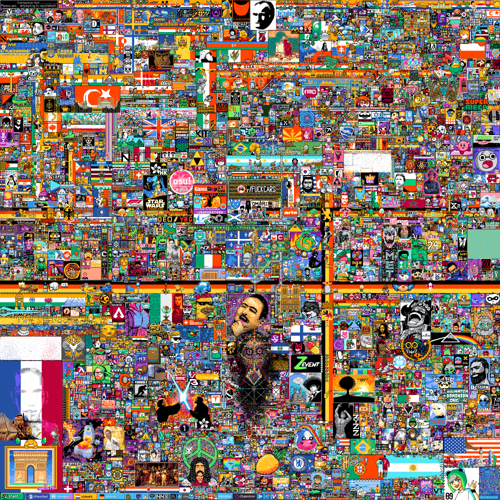

In [5]:
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path


def generate(
    infile, colorpath, agepath, start_ms=0, timescale=1000, frames=600, fps=60
):
    """Generate the age and color frames for the given file."""

    df = pd.read_parquet(infile)

    # The time gap between frames.
    dt = round(timescale * 1000 / fps)

    # earlier we converted the hex colors from the r/Place dataset to a key.
    # We can use this tuple to convert the key to an RGB color.
    indexed_rgb = (
        (0, 0, 0),
        (0, 117, 111),
        (0, 158, 170),
        (0, 163, 104),
        (0, 204, 120),
        (0, 204, 192),
        (36, 80, 164),
        (54, 144, 234),
        (73, 58, 193),
        (81, 82, 82),
        (81, 233, 244),
        (106, 92, 255),
        (109, 0, 26),
        (109, 72, 47),
        (126, 237, 86),
        (129, 30, 159),
        (137, 141, 144),
        (148, 179, 255),
        (156, 105, 38),
        (180, 74, 192),
        (190, 0, 57),
        (212, 215, 217),
        (222, 16, 127),
        (228, 171, 255),
        (255, 56, 129),
        (255, 69, 0),
        (255, 153, 170),
        (255, 168, 0),
        (255, 180, 112),
        (255, 214, 53),
        (255, 248, 184),
        (255, 255, 255),
    )

    # Generate the canvases to hold the running values
    img_color = Image.new("RGB", (2000, 2000), "white")
    px_birthtimes = np.zeros((2000, 2000), dtype="uint32")

    # Create an iterator that yields the rows of the dataset in order.
    px_iterator = df.itertuples()

    # Get the first pixel.
    px = next(px_iterator)

    # Create "frames_color" and "frames_age" directories if they don't already exist.
    # color_frames_abs_path.mkdir(exist_ok=True)
    # age_frames_abs_path.mkdir(exist_ok=True)

    # Iterate through the frames.
    for ms in range(start_ms, TIMESTAMP_MAX, dt):
        frame_no = (ms - start_ms) // dt
        if frame_no >= frames:
            # Stop after the last frame.
            break

        # Draw pixels where timestamp == ms
        # There may be multiple pixels with the same timestamp.
        while px.timestamp <= ms:
            # Draw the pixel's color to the color canvas.
            img_color.putpixel(
                (px.x, px.y),
                indexed_rgb[px.pixel_color],
            )
            # Draw the pixel's birthtime to the birthtime canvas.
            px_birthtimes[px.y, px.x] = px.timestamp
            try:
                # Get the next pixel.
                px = next(px_iterator)
            except StopIteration:
                # Break out of the loop if we've reached the end of the dataset.
                break

        # After all of the pixels less than the frame's timestamp have been drawn,
        # save the color and birthtime canvases as frames.
        filename = f"frame-{str(frame_no).zfill(4)}.png"

        # Subtract the birthtimes of the pixels from the current time to get their ages.
        # If the pixel has a timestamp of 0, treat it as having max age.
        # (it's one of the original white pixels)
        px_ages = np.where(
            px_birthtimes == 0, UINT16_MAX, age_to_val(ms - px_birthtimes)
        )

        # Convert the NumPy array to a Pillow 16-bit Image object.
        img_age = Image.fromarray(px_ages.astype("uint16"), "I;16")

        # Save the frames.
        img_age.save(agepath / filename, "PNG", optimize=True, bits=16)
        img_color.save(colorpath / filename, "PNG", optimize=True)



generate(
    Path("../data/2022_place_canvas_history.parquet"),
    Path("../data/frames_color"),
    Path("../data/frames_age"),
    # Start at the 72-hour mark.
    start_ms=(3 * 24 * 60 * 60 * 1000),
    # Only save the first frame.
    frames=1,
)

# Show the first color frame.
img_color = Image.open("../data/frames_color/frame-0000.png")

# Make a thumbnail of the color frame.
img_color.thumbnail((500, 500))
img_color

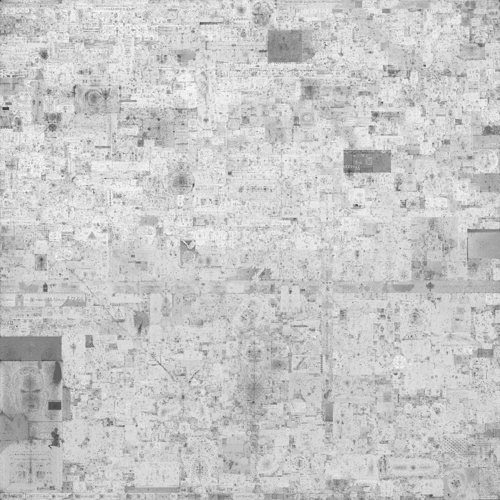

In [8]:
# Show the first age frame.
img_age = Image.open("../data/frames_age/frame-0000.png")

# Make a thumbnail of the age frame.
img_age.thumbnail((500, 500))
img_age